In [31]:
if True:
    %pip install -qqq numpy scipy matplotlib pandas scikit-learn seaborn tqdm

Note: you may need to restart the kernel to use updated packages.


In [32]:
import numpy as np # imports a fast numerical programming library
import matplotlib.pyplot as plt # sets up plotting under plt
import pandas as pd # lets us handle data as dataframes
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%load_ext autoreload
%autoreload 2

# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1: **Logistic Regression**

### **1.1: Log-likelihood and Gradient Ascent Rule** 

Write the likelihood $L(\theta)$ and log-likelihood $l(\theta)$ of the parameters $\theta$.

Recall the probabilistic interpretation of the hypothesis $h_\theta(x)= P(y=1|x;\theta)$ and that $h_\theta(x)=\frac{1}{1+\exp(-\theta^T x)}$.

Also derive the gradient $\frac{\delta l(\theta)}{\delta \theta_j}$ of $l(\theta)$ and write the gradient update equation. 

-------------------------------------------------------
- **Likelihood**: 

$$
L(\theta) = \prod_{i=1}^N P(y^{(i)} | x^{(i)}; \theta) = \prod_{i=1}^N (h_\theta(x^{(i)}))^{y^{(i)}} (1 - h_\theta(x^{(i)}))^{1 - y^{(i)}}
$$

- **Log-Likelihood**: 

$$
l(\theta) = \log L(\theta) = \sum_{i=1}^N \left[ y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right]
$$

- **Gradient of log-likelihood** (slide 5 p. 20):
$$
\frac{\partial l(\theta)}{\partial \theta_j} = \sum_{i=1}^N \left[ y^{(i)} - h_\theta(x^{(i)}) \right] x_j^{(i)}
$$

- **Gradient update equation**: 
For  $j=0,...,n$:
$$
\theta := \theta + \alpha \sum_{i=1}^N \left[ y^{(i)} - h_\theta(x^{(i)}) \right] x^{(i)}
$$

-------------------------------------------------------

In [3]:
from libs.models import LogisticRegression
from libs.optim import fit

**Check your grad_l implementation:**

`LogisticRegression.log_likelihood` applied to some random vectors should provide a value for `output_test` close to the `target_value` (defined below).
In other words, `error_test` should be close to 0.

In [4]:
target_value = -1
np.random.seed(1)
output_test = LogisticRegression.likelihood(np.random.random(100), np.random.randint(0, 2, 100))
error_test = np.abs(output_test - target_value)
print("Error: ", error_test)
assert error_test < 0.2, "The output is not correct"

Error:  0.031996098220603564


#### Preprocessing

In [5]:
data = pd.read_csv("assets/train.csv")
data.head()

,Id,island,sex,species,bill_length,bill_depth,flipper_length,body_mass
0,182,Biscoe,FEMALE,Gentoo,47.10,16.00,184.43,2862.01
1,39,Biscoe,FEMALE,Gentoo,55.63,7.55,187.28,3345.10
2,265,Torgersen,FEMALE,Adelie,35.03,19.80,202.43,3536.63
3,158,Biscoe,NaN,Gentoo,28.18,20.59,220.22,4235.40
4,254,Dream,MALE,Chinstrap,25.38,25.22,233.34,5732.33


We want to train a classifier capable of understanding the difference between Adelie and Gentoo solely based on their bill's length and body mass. Thus in order to preprocess the data we:
1. Drop all the items with null data.
2. Remove the third species (Chinstrap) from the dataset.
3. Select the features we're interested in (`bill_length`, `body_mass`).
4. Select the label data and encode it in the values 0 and 1.

<img src="https://allisonhorst.github.io/palmerpenguins/reference/figures/culmen_depth.png" width="500"/> 

In [6]:
data.dropna(inplace=True)
data = data[data["species"] != "Chinstrap"]
X = data[["bill_length", "body_mass"]]
y = data["species"].map({"Adelie": 0, "Gentoo": 1}).values

It is recommended to normalize data when using machine learning techniques, so now normalize $X$ to have $\mu=0, \sigma=1$.

In [ ]:
μ = X.mean(axis=0)  
σ = X.std(axis=0)   

X = (X - μ) / σ  

We add a column of 1's to $X$ to take into account the intercept.

In [26]:
X["bias"] = 1
# Reordering columns to have the bias term first (convention)
X = X[["bias", "bill_length", "body_mass"]] 
X

,bias,bill_length,body_mass
0,1,0.444021,-0.748712
1,1,1.022341,-0.507442
2,1,-0.374306,-0.411786
5,1,0.437241,0.633610
6,1,-1.496369,0.577329
...,...,...,...
196,1,0.808777,0.192532
197,1,-0.790588,-0.315580
198,1,-1.428571,0.093969
199,1,0.788437,-0.037037


#### Training

In [27]:
# Initialize the model
model = LogisticRegression(num_features=X.shape[1])

# Run Gradient Ascent method
n_iter = 50
log_l_history, _ = fit(model, X, y, lr=0.5, num_steps=n_iter)

Let's plot the log likelihood over different iterations:


Text(0.5, 0, 'Iterations')

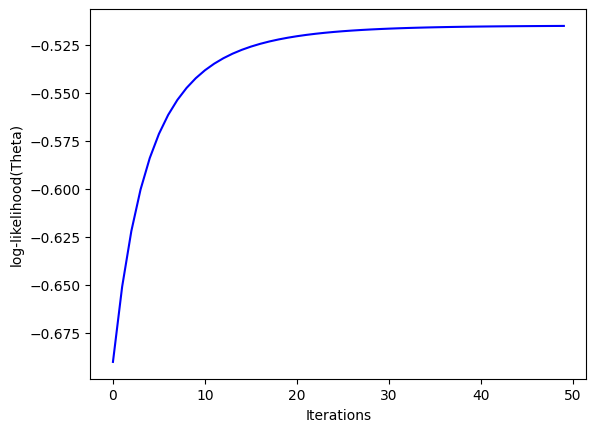

In [28]:
plt.plot(range(len(log_l_history)), log_l_history, "b")
plt.ylabel("log-likelihood(Theta)")
plt.xlabel("Iterations")

Plot the data and the decision boundary:

(-2.462430691501967, 2.5724825717974427)

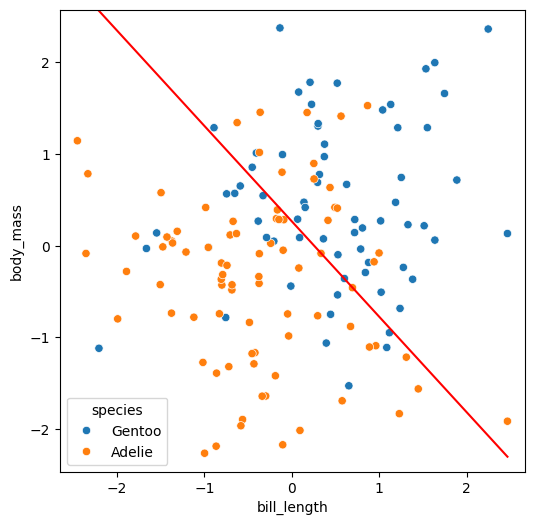

In [29]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=X, x="bill_length", y="body_mass", hue=data["species"])

x_range = np.linspace(X['bill_length'].min(), X['bill_length'].max(), 100)
theta_final = model.parameters
y_range = -(theta_final[0] + theta_final[1] * x_range) / theta_final[2]
plt.plot(x_range, y_range, c="red")

plt.xlim(X['bill_length'].min() - 0.2, X['bill_length'].max() + 0.2)
plt.ylim(X['body_mass'].min() - 0.2, X['body_mass'].max() + 0.2)

In [30]:
accuracy = ((model.predict(X) > 0.5) == y).mean()
print(f"Accuracy: {accuracy}")
assert accuracy > 0.6, "The accuracy is too low"

Accuracy: 0.7615894039735099


### **1.3: Report**

1. Are we looking for a local minimum or a local maximum using the gradient ascent rule? 
2. You have implemented the gradient ascent rule. Could we have also used gradient descent instead for the proposed problem? Why/Why not?
3. Let's deeply analyze how the learning rate $\alpha$ and the number of iterations affect the final results. Run the algorithm you have written for different values of $\alpha$ and the number of iterations and look at the outputs you get. Is the decision boundary influenced by these parameters change? Why do you think these parameters are affecting/not affecting the results?
4. What happens if you do not normalize the data? Try to run the algorithm without normalizing the data and see what happens. Why do you think this happens?